In [1]:
cd ../../

/workspaces/research/motor-decoding


In [2]:
import json
import sys
from collections import Counter
from itertools import cycle
from pathlib import Path

import dabest
import matplotlib.pyplot as plt
import seaborn as sns
import mne
import numpy as np
import pandas as pd

from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch
from mne_bids.read import read_raw_bids
from mne_bids import BIDSPath
from rerf.rerfClassifier import rerfClassifier
from scipy.io import loadmat
from scipy.spatial.distance import euclidean
from scipy import stats
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, accuracy_score, plot_confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, TimeSeriesSplit
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer, label_binarize
from tqdm import tqdm

from mtsmorf.io.read import read_dataset, read_label, read_trial, get_trial_info
from mtsmorf.io.utils import NumpyEncoder
from mtsmorf.io.experiments import cv_fit, run_classifier_comparison

from mtsmorf.move_exp.plotting import (
    plot_signals,
    plot_roc_multiclass_cv,
    plot_roc_cv,
    plot_feature_importances,
    plot_cv_indices,
    plot_accuracies
)

# plt.style.use(['science', 'ieee', 'no-latex'])

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
def filter_epochs(epochs, resample_rate=500):
    # Low-pass filter up to sfreq/2
    fs = epochs.info["sfreq"]
    new_epochs = epochs.filter(l_freq=0.5, h_freq=fs/2-1)

    # Downsample epochs to 500 Hz
    new_epochs = new_epochs.resample(resample_rate)

    return new_epochs

In [4]:
# bids_root = Path("/Users/ChesterHuynh/OneDrive - Johns Hopkins/research/data/efri/")
bids_root = Path("/workspaces/research/mnt/data/efri")

# subject identifiers
subject = "efri07"
session = "efri"
task = "move"
acquisition = "seeg"
run = "01"
kind = "ieeg"

bids_path = BIDSPath(subject=subject, session=session, task=task,
                     acquisition=acquisition, run=run, suffix=kind, extension=".vhdr", root=bids_root)

In [5]:
before = read_dataset(bids_path, kind='ieeg', tmin=0, tmax=1.0, picks=None, event_key="At Center", verbose=True)
before.load_data()
before_data = filter_epochs(before).get_data()

## tmin=-0.25 to capture initiation of mvmt
after = read_dataset(bids_path, kind='ieeg', tmin=-0.25, tmax=0.75, picks=None, event_key="Left Target", verbose=True)
after.load_data()
after_data = filter_epochs(after).get_data()

Extracting parameters from /workspaces/research/mnt/data/efri/sub-efri07/ses-efri/ieeg/sub-efri07_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr...
Setting channel info structure...
Reading events from /workspaces/research/mnt/data/efri/sub-efri07/ses-efri/ieeg/sub-efri07_ses-efri_task-move_acq-seeg_run-01_events.tsv.
Reading channel info from /workspaces/research/mnt/data/efri/sub-efri07/ses-efri/ieeg/sub-efri07_ses-efri_task-move_acq-seeg_run-01_channels.tsv.
Out of 98 trials, there were 96 successful trials in /workspaces/research/mnt/data/efri/sub-efri07/ses-efri/ieeg/sub-efri07_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr.
Used Annotations descriptions: ['At Center', 'False Start', 'Go Cue', 'Held Target', 'Hit Target', 'Left Target', 'Reserved (End Trial)', 'Reserved (Start Trial)', 'Reward', 'Show Center', 'Speed Fail', 'Speed Feedback', 'Speed Instruction']
Not setting metadata
Not setting metadata
98 matching events found
No baseline correction applied
0 projection items activat

In [6]:
ntrials, nchs, nsteps = before_data.shape

X = np.vstack([
    before_data.reshape(before_data.shape[0], -1),  # class 0
    after_data.reshape(after_data.shape[0], -1)     # class 1
])
y = np.concatenate([
    np.zeros(len(before_data)),
    np.ones(len(after_data))
])

assert X.shape[0] == y.shape[0], "X and y do not have the same number of samples"

print(X.shape, y.shape)

(194, 37500) (194,)


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


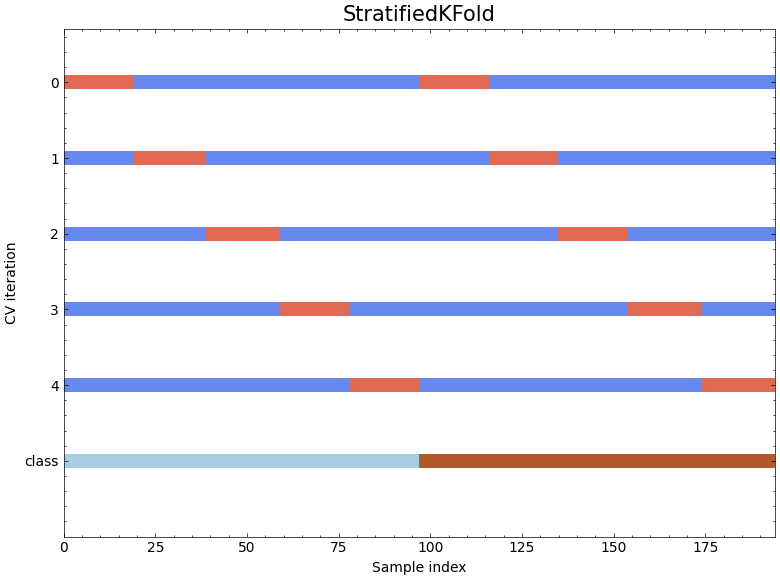

In [10]:
# Perform K-Fold cross validation
rng = 1
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=False)

fig, ax = plt.subplots(dpi=100, figsize=(8, 6))
argsort_inds = np.argsort(y)
plot_cv_indices(cv, X[argsort_inds], y[argsort_inds], ax, n_splits, lw=10)
fig.tight_layout();

### Time domain

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


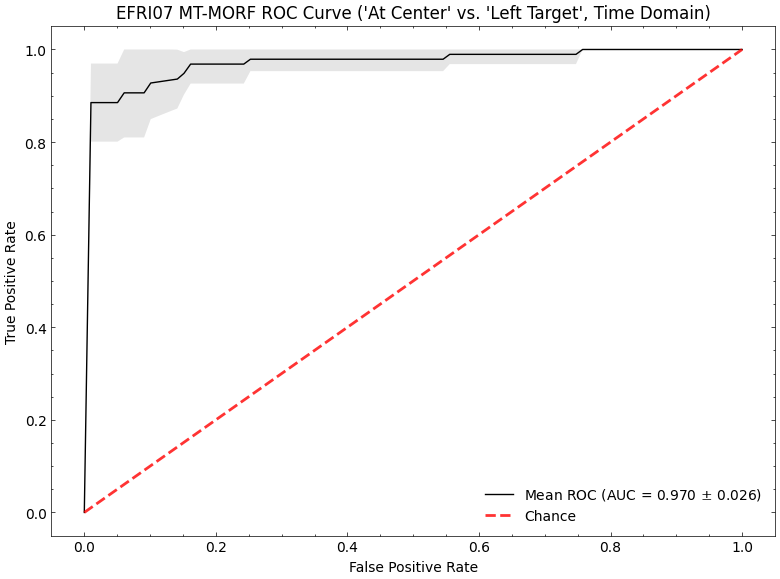

In [8]:
metrics = [
    'accuracy',
    'roc_auc_ovr',
]

mtsmorf = rerfClassifier(
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=nchs,
    image_width=nsteps,
)

## Cross validation. Fit model
stratified_kf_scores = cv_fit(mtsmorf, X, y, metrics=metrics, cv=cv, n_jobs=None, return_train_score=True, return_estimator=True)

## Plot results
fig, ax = plt.subplots(dpi=100, figsize=(8, 6))

plot_roc_cv(
    stratified_kf_scores["test_predict_proba"],
    X,
    y,
    stratified_kf_scores["test_inds"],
    ax=ax,
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"{subject.upper()} MT-MORF ROC Curve ('At Center' vs. 'Left Target', Time Domain)",
)
ax.legend(loc="lower right")
fig.tight_layout();

100%|██████████| 5/5 [03:56<00:00, 47.34s/it]


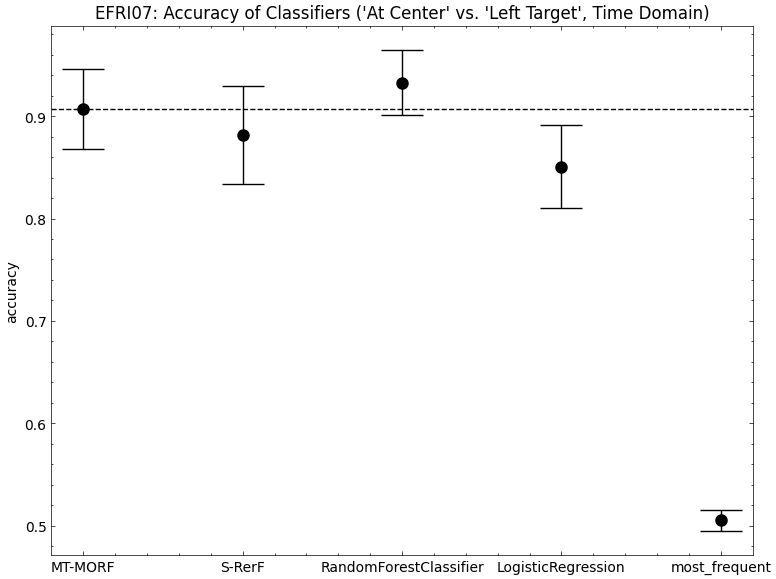

In [9]:
metrics = [
    'accuracy',
    'roc_auc_ovr',
]

mtsmorf = rerfClassifier(
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=nchs,
    image_width=nsteps,
)

srerf = rerfClassifier(
    projection_matrix="S-RerF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=nchs,
    image_width=nsteps,
)

lr = LogisticRegression(random_state=rng)
rf = RandomForestClassifier(random_state=rng)
dummy = DummyClassifier(strategy='most_frequent', random_state=rng)

clf_scores = dict()
clfs = [
    mtsmorf,
    srerf,
    rf,
    lr,
    dummy,
]

for clf in tqdm(clfs):
    if clf.__class__.__name__ == "rerfClassifier":
        clf_name = clf.get_params()["projection_matrix"]
    elif clf.__class__.__name__ == "DummyClassifier":
        clf_name = clf.strategy
    else:
        clf_name = clf.__class__.__name__

    clf_scores[clf_name] = cv_fit(
        clf,
        X,
        y,
        cv=cv,
        metrics=metrics,
        n_jobs=None,
        return_train_score=True,
        return_estimator=True,
    )

## Plot results
fig, ax = plt.subplots(dpi=100, figsize=(8,6))
plot_accuracies(clf_scores, ax=ax)
ax.set(ylabel="accuracy", title=f"{subject.upper()}: Accuracy of Classifiers ('At Center' vs. 'Left Target', Time Domain)")
fig.tight_layout();

### Freq domain
- `TODO`: For loop for each patient

In [6]:
nfreqs = 10
lfreq, hfreq = (70, 200)
freqs = np.logspace(*np.log10([lfreq, hfreq]), num=nfreqs)
n_cycles = freqs / 2.  # different number of cycle per frequency

after_power = tfr_morlet(after, freqs=freqs, n_cycles=n_cycles, average=False,
                   return_itc=False, decim=3, n_jobs=1).data
before_power = tfr_morlet(before, freqs=freqs, n_cycles=n_cycles, average=False,
                   return_itc=False, decim=3, n_jobs=1).data

Not setting metadata
Not setting metadata


In [7]:
ntrials, nchs, nfreqs, nsteps = before_power.shape

X = np.vstack([
    before_power.reshape(before_power.shape[0], -1),  # class 0
    after_power.reshape(after_power.shape[0], -1)     # class 1
])
y = np.concatenate([
    np.zeros(len(before_power)),
    np.ones(len(after_power))
])

assert X.shape[0] == y.shape[0], "X and y do not have the same number of epochs"

print(X.shape, y.shape)

(194, 125250) (194,)


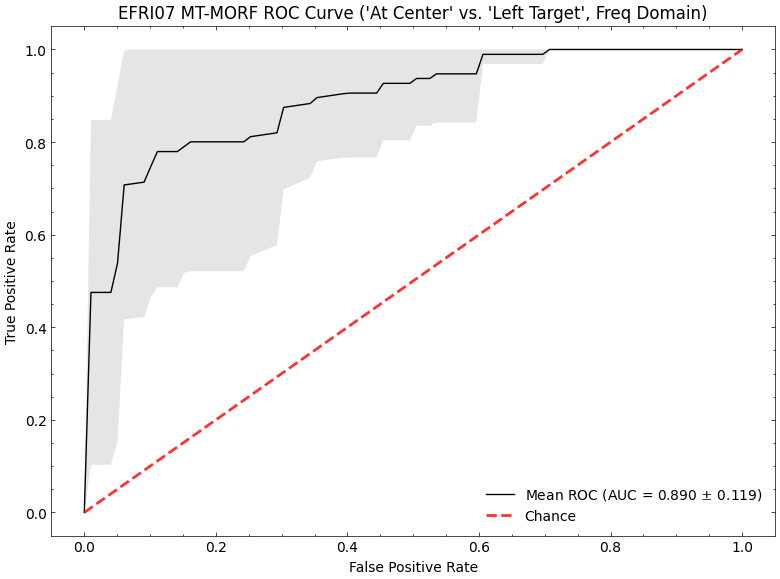

In [13]:
# Perform K-Fold cross validation
rng = 1
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=False)

metrics = [
    'accuracy',
    'roc_auc_ovr',
]

mtsmorf = rerfClassifier(
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=nchs*nfreqs,
    image_width=nsteps,
)

## Cross validation. Fit model
stratified_kf_scores = cv_fit(mtsmorf, X, y, metrics=metrics, cv=cv, n_jobs=None, return_train_score=True, return_estimator=True)

## Plot results
fig, ax = plt.subplots(dpi=100, figsize=(8, 6))

plot_roc_cv(
    stratified_kf_scores["test_predict_proba"],
    X,
    y,
    stratified_kf_scores["test_inds"],
    ax=ax,
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"{subject.upper()} MT-MORF ROC Curve ('At Center' vs. 'Left Target', Freq Domain)",
)
ax.legend(loc="lower right")
fig.tight_layout();

100%|██████████| 5/5 [11:19<00:00, 135.94s/it]
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


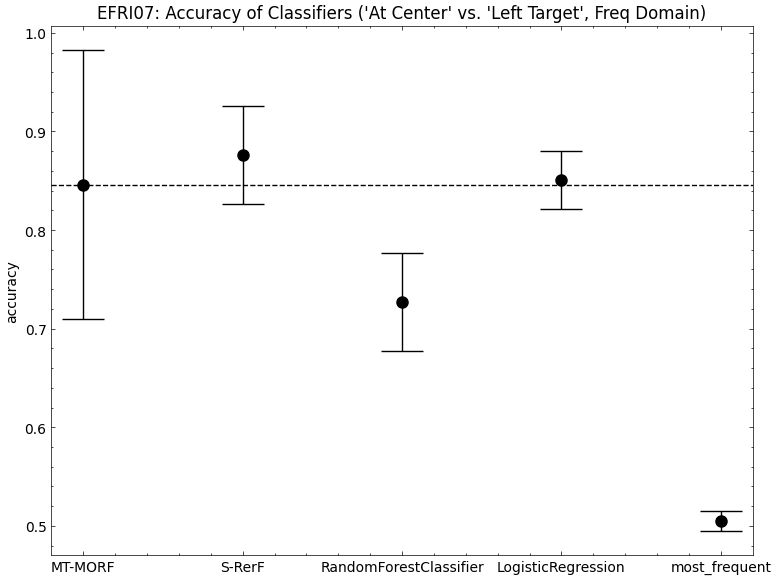

In [11]:
metrics = [
    'accuracy',
    'roc_auc_ovr',
]

mtsmorf = rerfClassifier(
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=nchs*nfreqs,
    image_width=nsteps,
)

srerf = rerfClassifier(
    projection_matrix="S-RerF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=nchs*nfreqs,
    image_width=nsteps,
)

lr = LogisticRegression(random_state=rng)
rf = RandomForestClassifier(random_state=rng)
dummy = DummyClassifier(strategy='most_frequent', random_state=rng)

clf_scores = dict()
clfs = [
    mtsmorf,
    srerf,
    rf,
    lr,
    dummy,
]

for clf in tqdm(clfs):
    if clf.__class__.__name__ == "rerfClassifier":
        clf_name = clf.get_params()["projection_matrix"]
    elif clf.__class__.__name__ == "DummyClassifier":
        clf_name = clf.strategy
    else:
        clf_name = clf.__class__.__name__

    clf_scores[clf_name] = cv_fit(
        clf,
        X,
        y,
        cv=cv,
        metrics=metrics,
        n_jobs=None,
        return_train_score=True,
        return_estimator=True,
    )

fig, ax = plt.subplots(dpi=100, figsize=(8,6))
plot_accuracies(clf_scores, ax=ax)
ax.set(ylabel="accuracy", title=f"{subject.upper()}: Accuracy of Classifiers ('At Center' vs. 'Left Target', Freq Domain)")
fig.tight_layout();